In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scikit_posthocs as sp


from scipy import stats


from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.decomposition import PCA

from imblearn.under_sampling import EditedNearestNeighbours




In [2]:
df = pd.read_csv("dataset_23_cmc.csv")
df

,Wifes_age,Wifes_education,Husbands_education,Number_of_children_ever_born,Wifes_religion,Wifes_now_working%3F,Husbands_occupation,Standard-of-living_index,Media_exposure,Contraceptive_method_used
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   Wifes_age                     1473 non-null   int64
 1   Wifes_education               1473 non-null   int64
 2   Husbands_education            1473 non-null   int64
 3   Number_of_children_ever_born  1473 non-null   int64
 4   Wifes_religion                1473 non-null   int64
 5   Wifes_now_working%3F          1473 non-null   int64
 6   Husbands_occupation           1473 non-null   int64
 7   Standard-of-living_index      1473 non-null   int64
 8   Media_exposure                1473 non-null   int64
 9   Contraceptive_method_used     1473 non-null   int64
dtypes: int64(10)
memory usage: 115.2 KB


In [4]:
target = "Contraceptive_method_used"

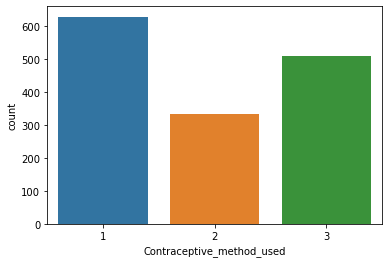

In [5]:
sns.countplot(x = df[target]);


**Normalização entre 0 - 1**

In [6]:
#normlizando 0 - 1
normalized_df = pd.DataFrame()
for i in df.columns:
    if i != target:
        normalized_df[i]=(df[i]-df[i].min())/(df[i].max()-df[i].min())
    else:
        normalized_df[i] = df[i]
        
normalized_df

,Wifes_age,Wifes_education,Husbands_education,Number_of_children_ever_born,Wifes_religion,Wifes_now_working%3F,Husbands_occupation,Standard-of-living_index,Media_exposure,Contraceptive_method_used
0,0.242424,0.333333,0.666667,0.1875,1.0,1.0,0.333333,0.666667,0.0,1
1,0.878788,0.000000,0.666667,0.6250,1.0,1.0,0.666667,1.000000,0.0,1
2,0.818182,0.333333,0.666667,0.4375,1.0,1.0,0.666667,1.000000,0.0,1
3,0.787879,0.666667,0.333333,0.5625,1.0,1.0,0.666667,0.666667,0.0,1
4,0.606061,0.666667,0.666667,0.5000,1.0,1.0,0.666667,0.333333,0.0,1
...,...,...,...,...,...,...,...,...,...,...
1468,0.515152,1.000000,1.000000,0.1250,1.0,0.0,0.333333,1.000000,0.0,3
1469,0.515152,1.000000,1.000000,0.1875,1.0,1.0,0.000000,1.000000,0.0,3
1470,0.696970,0.666667,0.666667,0.5000,1.0,0.0,0.000000,1.000000,0.0,3
1471,0.515152,0.666667,0.666667,0.2500,1.0,0.0,0.333333,0.333333,0.0,3


**EXPERIMENTO**

In [36]:
def classificador(model,X_train, X_test,y_train, y_test):
    
    
    if type(model).__name__ in ["SVC"] :
        y_t = label_binarize(y_train, classes=[1, 2, 3])
        y_te = label_binarize(y_test, classes=[1, 2,3])
        n_classes = y_t.shape[1]

        classifier = OneVsRestClassifier(model)

        aucs =[]
        y_score = classifier.fit(X_train, y_t).decision_function(X_test)
        for i in range(n_classes):
            fpr, tpr, AUC = roc_curve(y_te[:, i], y_score[:, i])
            aucs.append(auc(fpr,tpr))
            roc = sum(aucs)/3
        model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train)
        roc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')

    
    
    new_row = {"ACC":accuracy_score(y_test, model.predict(X_test)),
               "F1":f1_score(y_test, model.predict(X_test), average='weighted'),
                  "AUC":roc}

    matrix_confusao = confusion_matrix(y_test,model.predict(X_test))



    return (new_row, matrix_confusao)

#Mudar para plotar a matriz de confusão média
def plotMatrizConfusao(matriz_list,ax):
    sum = [[0,0,0],[0,0,0],[0,0,0]]
    for i in range(len(matriz_list)):
        sum = sum + matriz_list[i]
        
            
    sns.heatmap(sum/len(matriz_list), annot=True,ax=ax)
    

In [8]:
def otimizadorDeHype(name,X_train,y_train):
    cv = 3
    if name=='knn':
        limite_superior = 100
        limite_inferior = 1 
        limite = list(range(limite_inferior,limite_superior))
        #Parametros a serem escolhidos
        params = {'n_neighbors':limite, 'metric':['euclidean','manhattan']}
        #istanciando 
        gridS = GridSearchCV(KNeighborsClassifier(),params,cv=cv,n_jobs=-1,scoring='accuracy')
        #treinando o grid 
        grid_result = gridS.fit(X_train,y_train)
        return KNeighborsClassifier(metric = grid_result.best_params_['metric'],
                                    n_neighbors = grid_result.best_params_['n_neighbors']  )
    
    if name== 'mlp':
        mlp = MLPClassifier(max_iter=1000)

        params = {
            'hidden_layer_sizes': [(8,8),(316,16),(32,32), (32,64), (64,128)],
            'activation': ['tanh', 'relu'],
            'solver':['sgd','adam'],
            'alpha':[0.0001, 0.05],
            'learning_rate': ['constante','adaptive'],
        }

        gridS = GridSearchCV(mlp,params,n_jobs=-1,cv=cv,scoring='accuracy')
        
        grid_result = gridS.fit(X_train,y_train)
        return MLPClassifier(hidden_layer_sizes=grid_result.best_params_['hidden_layer_sizes'], 
                    activation=grid_result.best_params_['activation'], solver=grid_result.best_params_['solver'],
                    alpha=grid_result.best_params_['alpha'],
                    learning_rate=grid_result.best_params_['learning_rate'], max_iter=100000)
    if name == 'df':
        
        df = DecisionTreeClassifier()
        params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': list(range(2, 10)),
                  'max_depth':list(range(2, 15)),'criterion':["gini", "entropy"]}
        
        gridS = GridSearchCV(df,params,cv=cv,n_jobs=-1,scoring='accuracy')
        
        grid_result = gridS.fit(X_train,y_train)
        return DecisionTreeClassifier(max_leaf_nodes = grid_result.best_params_['max_leaf_nodes'],
                                      min_samples_split=grid_result.best_params_['min_samples_split'] ,
                                     max_depth=  grid_result.best_params_['max_depth'],
                                     criterion = grid_result.best_params_['criterion'])
    if name == "nb":
        
        nb = GaussianNB()
        
        params = {'var_smoothing': np.logspace(0,-9, num=100)}
        
        gridS = GridSearchCV(nb,params,cv=cv,n_jobs=-1,scoring='accuracy')
        
        grid_result = gridS.fit(X_train,y_train)
        return GaussianNB(var_smoothing=grid_result.best_params_['var_smoothing'])
        
        return LogisticRegression(solver='liblinear', penalty=grid_result.best_params_['penalty'])
    if name == "svm":
        
        svm = SVC()
        
        params = {"kernel": ['rbf'], 'C': list(range(1, 100))}
        
        gridS = GridSearchCV(svm ,params,cv=cv,n_jobs=-1,scoring='accuracy')
                                                                                       
        grid_result = gridS.fit(X_train,y_train)
        return SVC(kernel=grid_result.best_params_['kernel'], C=grid_result.best_params_['C'])

In [9]:
def run(X, y, splits_kfold, pre=False, pca=False):
    kf = StratifiedKFold(n_splits=splits_kfold,random_state=42)
    kf.get_n_splits(X,y)

    metrics = ["ACC","F1","AUC"]


    matriz_knn = []
    matriz_tree = []
    matriz_mlp = []
    matriz_nb = []
    matriz_reg_log = []
    matriz_svm = []

    df_knn = pd.DataFrame(columns=metrics)
    df_tree = pd.DataFrame(columns=metrics)
    df_mlp = pd.DataFrame(columns=metrics)
    df_nb = pd.DataFrame(columns=metrics)
    df_reg_log = pd.DataFrame(columns=metrics)
    df_svm = pd.DataFrame(columns=metrics)



    for train_index, test_index in kf.split(X,y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if pre == True:
            resampler = EditedNearestNeighbours(n_neighbors=3, sampling_strategy="auto", kind_sel="mode")
            X_train, y_train = resampler.fit_resample(X_train, y_train)
        
        if pca == True:
            #PCA com 3 componetnes
            pca = PCA(n_components=3)
            X = pca.fit_transform(X)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            


        model = otimizadorDeHype("knn",X_train,y_train)
        line, matrix = classificador(model,X_train, X_test,y_train, y_test)
        df_knn = df_knn.append(line, ignore_index=True)
        matriz_knn.append(matrix)



        model = otimizadorDeHype("df",X_train,y_train)
        line, matrix = classificador(model,X_train, X_test,y_train, y_test)
        df_tree = df_tree.append(line, ignore_index=True)
        matriz_tree.append(matrix)   



        model = otimizadorDeHype("mlp",X_train,y_train)
        line, matrix = classificador(model,X_train, X_test,y_train, y_test)
        df_mlp = df_mlp.append(line, ignore_index=True)
        matriz_mlp.append(matrix)  


        model = otimizadorDeHype("nb",X_train,y_train)
        line, matrix = classificador(model,X_train, X_test,y_train, y_test)
        df_nb = df_nb.append(line, ignore_index=True)
        matriz_nb.append(matrix) 
        
        model = otimizadorDeHype("svm",X_train,y_train)
        line, matrix = classificador(model,X_train, X_test,y_train, y_test)
        df_svm = df_svm.append(line, ignore_index=True)
        matriz_svm.append(matrix)
        
    return [df_knn,df_tree,df_mlp,df_nb,df_svm ],[matriz_knn,matriz_tree,matriz_mlp,matriz_nb,matriz_svm]

In [11]:
X = normalized_df.drop(target, axis=1).values
y = normalized_df[target].values
splits_kfold = 10

## Treinamento sem Pré Processamento

In [12]:
dataframes,matrizes = run(X,y,splits_kfold)

C:\Users\bhla\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


## Treinamento com Pré Processamento ENN

In [13]:
dataframes_pre_enn, matrizes_pre_enn = run(X,y,splits_kfold,True,False)

C:\Users\bhla\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


## Treinamento com Pré Processamento PCA

In [14]:
dataframes_pre_pca, matrizes_pre_pca = run(X,y,splits_kfold,True,False)

C:\Users\bhla\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


## Experimento com Pré Processamento ENN + PCA

In [15]:
dataframes_pre_enn_pca, matrizes_pre_enn_pca = run(X,y,splits_kfold,True,True)

C:\Users\bhla\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


## Experimento com Pré Processamento PCA + ENN

In [16]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
dataframes_pre_pca_enn, matrizes_pre_pca_enn = run(X_pca,y,splits_kfold,True,False)

C:\Users\bhla\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


## Resultados

In [17]:
def result(dataframes,metrica):
    df_result = pd.DataFrame()
    df_result["KNN"] = dataframes[0][metrica]
    df_result["TREE"] = dataframes[1][metrica]
    df_result["MLP"] = dataframes[2][metrica]
    df_result["NB"] = dataframes[3][metrica]
    df_result["SVM"] = dataframes[4][metrica]
    return df_result

**Acurácia Geral**

In [18]:
print("RESULTADO SEM PRE PROCESSAMENTO")
result(dataframes,"ACC").describe()

RESULTADO SEM PRE PROCESSAMENTO


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.501066,0.551976,0.548534,0.460310,0.531600
std,0.047610,0.031087,0.044828,0.038887,0.021548
min,0.432432,0.486486,0.503401,0.385135,0.500000
25%,0.460275,0.534692,0.512721,0.433673,0.518707
50%,0.503401,0.557823,0.545735,0.467802,0.534014
75%,0.543126,0.577255,0.557823,0.487279,0.546527
max,0.557823,0.585034,0.653061,0.517007,0.564626


In [19]:
print("RESULTADO COM PRE PROCESSAMENTO ENN")
result(dataframes_pre_enn,"ACC").describe()

RESULTADO COM PRE PROCESSAMENTO ENN


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.435195,0.524117,0.509855,0.437213,0.486151
std,0.031720,0.022543,0.023804,0.039104,0.036423
min,0.401361,0.496599,0.472973,0.371622,0.398649
25%,0.413851,0.511031,0.488934,0.422745,0.477891
50%,0.428571,0.516892,0.520408,0.431973,0.488141
75%,0.449945,0.534014,0.528912,0.454082,0.501701
max,0.496599,0.564626,0.533784,0.500000,0.537415


In [20]:
print("RESULTADO COM PRE PROCESSAMENTO PCA")
result(dataframes_pre_pca,"ACC").describe()

RESULTADO COM PRE PROCESSAMENTO PCA


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.435195,0.518680,0.503075,0.437213,0.486151
std,0.031720,0.026265,0.030408,0.039104,0.036423
min,0.401361,0.476190,0.459459,0.371622,0.398649
25%,0.413851,0.507619,0.487314,0.422745,0.477891
50%,0.428571,0.515260,0.496599,0.431973,0.488141
75%,0.449945,0.522925,0.518707,0.454082,0.501701
max,0.496599,0.564626,0.564626,0.500000,0.537415


In [21]:
print("RESULTADO COM PRE PROCESSAMENTO ENN+PCA")
result(dataframes_pre_enn_pca,"ACC").describe()

RESULTADO COM PRE PROCESSAMENTO ENN+PCA


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.422964,0.419535,0.440600,0.432465,0.431757
std,0.024075,0.041424,0.034298,0.033393,0.036342
min,0.401361,0.367347,0.371622,0.371622,0.371622
25%,0.406095,0.389456,0.423469,0.414966,0.414966
50%,0.411565,0.415541,0.450841,0.440683,0.425170
75%,0.431467,0.450071,0.455782,0.448980,0.455012
max,0.476190,0.482993,0.493243,0.476190,0.493243


In [22]:
print("RESULTADO COM PRE PROCESSAMENTO PCA+ENN")
result(dataframes_pre_pca_enn,"ACC").describe()

RESULTADO COM PRE PROCESSAMENTO PCA+ENN


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.423649,0.420914,0.433126,0.434492,0.432451
std,0.024446,0.051354,0.020568,0.038611,0.033135
min,0.408163,0.346939,0.412162,0.371622,0.371622
25%,0.409163,0.385790,0.421769,0.412541,0.421769
50%,0.412162,0.421769,0.425170,0.438776,0.428571
75%,0.425170,0.450680,0.439741,0.448980,0.444843
max,0.482993,0.506757,0.476190,0.500000,0.493243


**F1-Score Geral**

In [23]:
print("RESULTADO SEM PRE PROCESSAMENTO")
result(dataframes,"F1").describe()

RESULTADO SEM PRE PROCESSAMENTO


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.498426,0.546907,0.543946,0.459060,0.527287
std,0.044993,0.029565,0.046038,0.036814,0.023388
min,0.435822,0.496519,0.498583,0.392321,0.485984
25%,0.459747,0.523381,0.512330,0.436406,0.510397
50%,0.500789,0.549968,0.536852,0.462068,0.532897
75%,0.541319,0.569605,0.558865,0.489088,0.538371
max,0.553529,0.581488,0.654216,0.510943,0.566479


In [24]:
print("RESULTADO COM PRE PROCESSAMENTO")
result(dataframes_pre_enn,"F1").describe()

RESULTADO COM PRE PROCESSAMENTO


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.433228,0.523118,0.508467,0.428022,0.484275
std,0.035710,0.021394,0.027249,0.044441,0.038691
min,0.383220,0.494302,0.459938,0.370103,0.391240
25%,0.410218,0.515064,0.485692,0.396924,0.479619
50%,0.422407,0.521380,0.517534,0.417480,0.483897
75%,0.451581,0.525303,0.530746,0.460327,0.493609
max,0.497185,0.562779,0.538404,0.509781,0.536626


In [25]:
print("RESULTADO COM PRE PROCESSAMENTO PCA")
result(dataframes_pre_pca,"F1").describe()

RESULTADO COM PRE PROCESSAMENTO PCA


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.433228,0.517287,0.500233,0.428022,0.484275
std,0.035710,0.026401,0.033668,0.044441,0.038691
min,0.383220,0.474653,0.448966,0.370103,0.391240
25%,0.410218,0.500307,0.486154,0.396924,0.479619
50%,0.422407,0.517313,0.490815,0.417480,0.483897
75%,0.451581,0.524119,0.518573,0.460327,0.493609
max,0.497185,0.562779,0.568564,0.509781,0.536626


In [26]:
print("RESULTADO COM PRE PROCESSAMENTO ENN+PCA")
result(dataframes_pre_enn_pca,"F1").describe()

RESULTADO COM PRE PROCESSAMENTO ENN+PCA


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.418932,0.412872,0.406350,0.349403,0.401256
std,0.023380,0.043969,0.044373,0.030742,0.053333
min,0.399887,0.356428,0.336875,0.306389,0.310264
25%,0.402971,0.380020,0.370473,0.332035,0.377979
50%,0.408174,0.409266,0.405602,0.351572,0.410354
75%,0.425747,0.451904,0.440794,0.361281,0.428886
max,0.470038,0.479764,0.475538,0.405795,0.481995


In [27]:
print("RESULTADO COM PRE PROCESSAMENTO PCA+ENN")
result(dataframes_pre_pca_enn,"F1").describe()

RESULTADO COM PRE PROCESSAMENTO PCA+ENN


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.418557,0.411457,0.394886,0.347506,0.397737
std,0.024126,0.048558,0.024327,0.029366,0.048023
min,0.399887,0.346136,0.348199,0.306389,0.309679
25%,0.405364,0.368102,0.382754,0.330468,0.375525
50%,0.410394,0.413687,0.393615,0.349029,0.407743
75%,0.413260,0.447058,0.406872,0.361281,0.416239
max,0.476101,0.481456,0.433254,0.398179,0.485416


**AUC**

In [28]:
print("RESULTADO SEM PRE PROCESSAMENTO")
result(dataframes,"AUC").describe()

RESULTADO SEM PRE PROCESSAMENTO


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.682595,0.708793,0.728866,0.662633,0.699643
std,0.024570,0.025912,0.024183,0.024231,0.019296
min,0.637432,0.669533,0.695766,0.626326,0.671165
25%,0.672371,0.690442,0.711366,0.649094,0.685531
50%,0.687305,0.707762,0.724763,0.658793,0.701053
75%,0.700344,0.728157,0.745485,0.684587,0.715187
max,0.711948,0.754082,0.772883,0.696508,0.724361


In [29]:
print("RESULTADO COM PRE PROCESSAMENTO")
result(dataframes_pre_enn,"AUC").describe()

RESULTADO COM PRE PROCESSAMENTO


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.587029,0.697205,0.715201,0.657516,0.686883
std,0.021270,0.026035,0.029297,0.019171,0.031705
min,0.561916,0.662642,0.677512,0.630623,0.635162
25%,0.573220,0.673462,0.694368,0.642836,0.667202
50%,0.584218,0.701194,0.707747,0.662078,0.688836
75%,0.592534,0.714651,0.737292,0.671752,0.698949
max,0.631119,0.737784,0.770153,0.681209,0.745554


In [30]:
print("RESULTADO COM PRE PROCESSAMENTO PCA")
result(dataframes_pre_pca,"AUC").describe()

RESULTADO COM PRE PROCESSAMENTO PCA


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.587029,0.693381,0.707185,0.657516,0.686883
std,0.021270,0.025288,0.020645,0.019171,0.031705
min,0.561916,0.661549,0.677873,0.630623,0.635162
25%,0.573220,0.671840,0.693198,0.642836,0.667202
50%,0.584218,0.692206,0.709920,0.662078,0.688836
75%,0.592534,0.705030,0.718274,0.671752,0.698949
max,0.631119,0.737784,0.739820,0.681209,0.745554


In [31]:
print("RESULTADO COM PRE PROCESSAMENTO ENN+PCA")
result(dataframes_pre_enn_pca,"AUC").describe()

RESULTADO COM PRE PROCESSAMENTO ENN+PCA


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.576902,0.578725,0.635880,0.629578,0.605182
std,0.024080,0.025509,0.029656,0.023054,0.029631
min,0.547929,0.545983,0.579607,0.598696,0.560222
25%,0.562185,0.563916,0.613905,0.611249,0.593814
50%,0.570169,0.573453,0.647168,0.623967,0.602488
75%,0.584744,0.588091,0.659742,0.650230,0.614988
max,0.618194,0.624949,0.666545,0.660573,0.665130


In [32]:
print("RESULTADO COM PRE PROCESSAMENTO PCA+ENN")
result(dataframes_pre_pca_enn,"AUC").describe()

RESULTADO COM PRE PROCESSAMENTO PCA+ENN


,KNN,TREE,MLP,NB,SVM
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.572897,0.576222,0.638428,0.629443,0.609082
std,0.020784,0.023945,0.023800,0.023186,0.029853
min,0.552088,0.539782,0.605335,0.598993,0.560222
25%,0.558218,0.558966,0.620066,0.611726,0.598397
50%,0.567071,0.574324,0.640504,0.622302,0.610456
75%,0.581158,0.590573,0.651353,0.651517,0.621552
max,0.622302,0.610851,0.673574,0.660479,0.665914


## Matrizes

**KNN Resultados**

Plot das matrizes de confusão

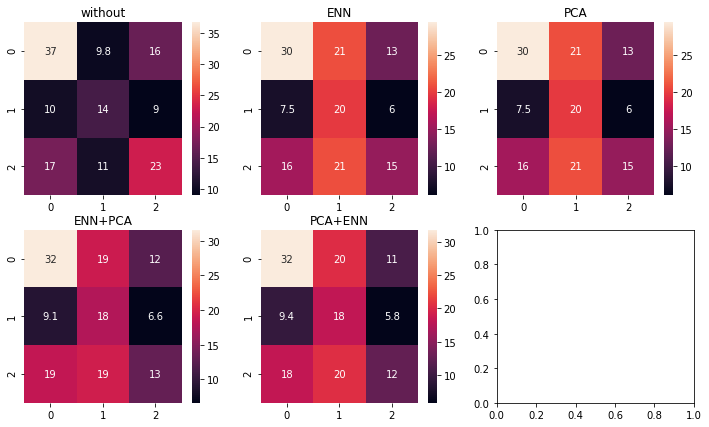

In [57]:
aux = 0
f, axes = plt.subplots(2, 3,figsize=(12,7))
plotMatrizConfusao(matrizes[aux],ax=axes[0][0])

axes[0][0].set_title('without')
plotMatrizConfusao(matrizes_pre_enn[aux],ax=axes[0][1])
axes[0][1].set_title('ENN')
plotMatrizConfusao(matrizes_pre_pca[aux],ax=axes[0][2])
axes[0][2].set_title('PCA')
plotMatrizConfusao(matrizes_pre_enn_pca[aux],ax=axes[1][0])
axes[1][0].set_title('ENN+PCA')
plotMatrizConfusao(matrizes_pre_pca_enn[aux],ax=axes[1][1])
axes[1][1].set_title('PCA+ENN');


**DT Resutaldos**

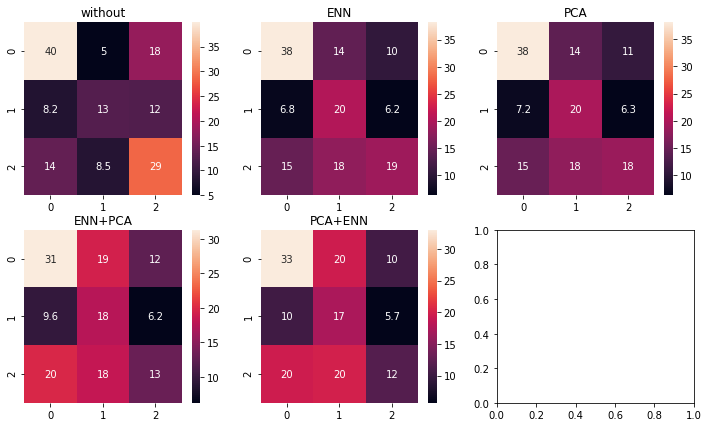

In [59]:
aux = 1
f, axes = plt.subplots(2, 3,figsize=(12,7))
plotMatrizConfusao(matrizes[aux],ax=axes[0][0])

axes[0][0].set_title('without')
plotMatrizConfusao(matrizes_pre_enn[aux],ax=axes[0][1])
axes[0][1].set_title('ENN')
plotMatrizConfusao(matrizes_pre_pca[aux],ax=axes[0][2])
axes[0][2].set_title('PCA')
plotMatrizConfusao(matrizes_pre_enn_pca[aux],ax=axes[1][0])
axes[1][0].set_title('ENN+PCA')
plotMatrizConfusao(matrizes_pre_pca_enn[aux],ax=axes[1][1])
axes[1][1].set_title('PCA+ENN');


**Multilayer Perceptron Resultados**

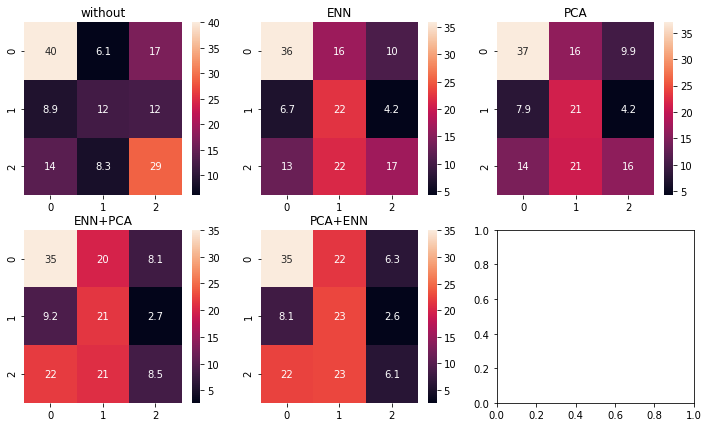

In [60]:
aux = 2
f, axes = plt.subplots(2, 3,figsize=(12,7))
plotMatrizConfusao(matrizes[aux],ax=axes[0][0])

axes[0][0].set_title('without')
plotMatrizConfusao(matrizes_pre_enn[aux],ax=axes[0][1])
axes[0][1].set_title('ENN')
plotMatrizConfusao(matrizes_pre_pca[aux],ax=axes[0][2])
axes[0][2].set_title('PCA')
plotMatrizConfusao(matrizes_pre_enn_pca[aux],ax=axes[1][0])
axes[1][0].set_title('ENN+PCA')
plotMatrizConfusao(matrizes_pre_pca_enn[aux],ax=axes[1][1])
axes[1][1].set_title('PCA+ENN');


**Naive Bayes Resultados**

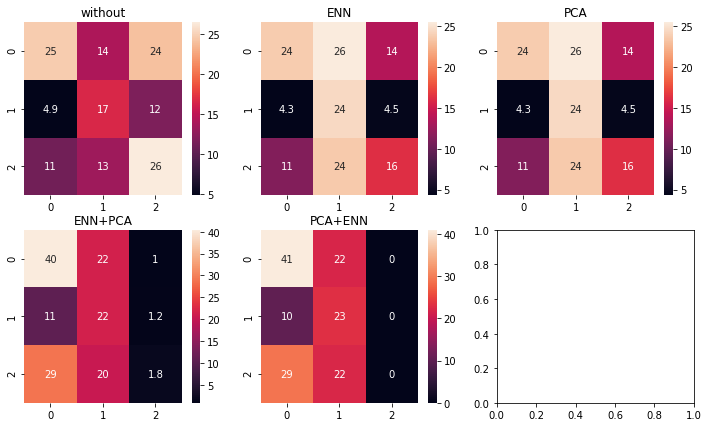

In [62]:
aux = 3
f, axes = plt.subplots(2, 3,figsize=(12,7))
plotMatrizConfusao(matrizes[aux],ax=axes[0][0])

axes[0][0].set_title('without')
plotMatrizConfusao(matrizes_pre_enn[aux],ax=axes[0][1])
axes[0][1].set_title('ENN')
plotMatrizConfusao(matrizes_pre_pca[aux],ax=axes[0][2])
axes[0][2].set_title('PCA')
plotMatrizConfusao(matrizes_pre_enn_pca[aux],ax=axes[1][0])
axes[1][0].set_title('ENN+PCA')
plotMatrizConfusao(matrizes_pre_pca_enn[aux],ax=axes[1][1])
axes[1][1].set_title('PCA+ENN');


**SVM**

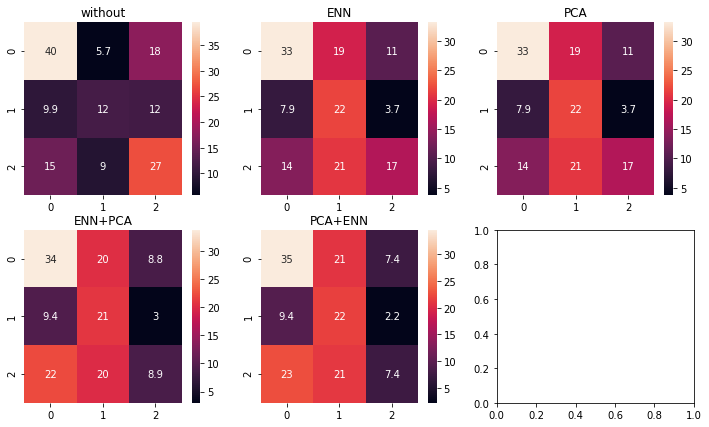

In [61]:
aux = 4
f, axes = plt.subplots(2, 3,figsize=(12,7))s
plotMatrizConfusao(matrizes[aux],ax=axes[0][0])

axes[0][0].set_title('without')
plotMatrizConfusao(matrizes_pre_enn[aux],ax=axes[0][1])
axes[0][1].set_title('ENN')
plotMatrizConfusao(matrizes_pre_pca[aux],ax=axes[0][2])
axes[0][2].set_title('PCA')
plotMatrizConfusao(matrizes_pre_enn_pca[aux],ax=axes[1][0])
axes[1][0].set_title('ENN+PCA')
plotMatrizConfusao(matrizes_pre_pca_enn[aux],ax=axes[1][1])
axes[1][1].set_title('PCA+ENN');


## Teste estatisticos

**Shapiro-Wilk**

In [76]:
lista_algoritmos = ["KNN","TREE","MLP","NB","SVM"]
lista_metricas = ["ACC","F1","AUC"] 
p = 0.05
for i, val in enumerate(lista_algoritmos):
    for j in lista_metricas:
        if stats.shapiro(dataframes[i][j])[1] <p:
            print("Normal em "+val+" "+j+" Whitout")
            
        if stats.shapiro(dataframes_pre_enn[i][j])[1] <p:
            print("Normal em "+val+" "+j+" ENN")
        
        if stats.shapiro(dataframes_pre_pca[i][j])[1] <p:
            print("Normal em "+val+" "+j+" PCA")
            
        if stats.shapiro(dataframes_pre_enn_pca[i][j])[1] <p:
            print("Normal em "+val+" "+j+" ENN+PCA")
            
        if stats.shapiro(dataframes_pre_pca_enn[i][j])[1] <p:
            print("Normal em "+val+" "+j+" PCA+ENN")
            
        

Normal em KNN ACC ENN+PCA
Normal em KNN ACC PCA+ENN
Normal em KNN F1 ENN+PCA
Normal em KNN F1 PCA+ENN
Normal em MLP ACC ENN
Normal em SVM F1 ENN
Normal em SVM F1 PCA


**Teste Estátistico kruskal**

In [88]:
for i, val in enumerate(lista_algoritmos):
    for j in lista_metricas:
        print(j+" "+val)
        
        print(stats.kruskal(dataframes[i][j],dataframes_pre_enn[i][j],  dataframes_pre_pca[i][j],dataframes_pre_enn_pca[i][j],dataframes_pre_pca_enn[i][j])[1])
    print()

ACC KNN
0.0013267663402402386
F1 KNN
0.0013373154438415544
AUC KNN
2.9200100425006464e-05

ACC TREE
2.22982176554164e-07
F1 TREE
1.560246701705691e-07
AUC TREE
3.0856779264911406e-07

ACC MLP
3.1538918527976384e-07
F1 MLP
1.6662819860102399e-07
AUC MLP
2.2421291449056522e-07

ACC NB
0.4973633280403835
F1 NB
1.4529069393130782e-06
AUC NB
0.003856910836800231

ACC SVM
3.7547817437747687e-06
F1 SVM
1.986997218177889e-06
AUC SVM
8.984213197358242e-07



**Teste Estátistico Dunn's**

In [95]:
for i, val in enumerate(lista_algoritmos):
    for j in lista_metricas:
        print(j+" "+val)
        print("   Whitout     ENN       PCA      ENN+PCA   PCA+ENN")
        lista_aux = [dataframes[i][j],dataframes_pre_enn[i][j],  dataframes_pre_pca[i][j],dataframes_pre_enn_pca[i][j],dataframes_pre_pca_enn[i][j]]
        print(sp.posthoc_dunn(lista_aux))
    print()

ACC KNN
   Whitout     ENN       PCA      ENN+PCA   PCA+ENN
          1         2         3         4         5
1  1.000000  0.004992  0.004992  0.000209  0.000427
2  0.004992  1.000000  1.000000  0.368149  0.474398
3  0.004992  1.000000  1.000000  0.368149  0.474398
4  0.000209  0.368149  0.368149  1.000000  0.853539
5  0.000427  0.474398  0.474398  0.853539  1.000000
F1 KNN
   Whitout     ENN       PCA      ENN+PCA   PCA+ENN
          1         2         3         4         5
1  1.000000  0.010397  0.010397  0.000238  0.000285
2  0.010397  1.000000  1.000000  0.265969  0.286260
3  0.010397  1.000000  1.000000  0.265969  0.286260
4  0.000238  0.265969  0.265969  1.000000  0.963286
5  0.000285  0.286260  0.286260  0.963286  1.000000
AUC KNN
   Whitout     ENN       PCA      ENN+PCA   PCA+ENN
          1         2         3         4         5
1  1.000000  0.001083  0.001083  0.000018  0.000006
2  0.001083  1.000000  1.000000  0.307571  0.211123
3  0.001083  1.000000  1.000000  0.307571